In [48]:
# import statements:
import run_analysis
import os
print os.getcwd()
os.chdir('/home/sjarvis1/workspace/co_optogenetics')
print os.getcwd()
import numpy as np
import math
%load_ext autoreload
%autoreload 2
reload(run_analysis)
import file_io as fio

/home/sjarvis1/workspace/co_optogenetics
/home/sjarvis1/workspace/co_optogenetics
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pylab
%pylab inline
from run_analysis import ExperimentPlotter
from matplotlib import cm, colors

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
# taken from https://gist.github.com/dmeliza/3251476

from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        
        #print("Testing in here!")
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, fc="none"))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, fc="none"))

        if sizex and labelx:
            #print("Testing in here! VPacker")
            bars = VPacker(children=[bars, TextArea(labelx, minimumdescent=False)],
                           align="center", pad=0, sep=sep)
        if sizey and labely:
            bars = HPacker(children=[TextArea(labely), bars],
                            align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)

    return sb

In [65]:
# Helper functions and constants
OPSIN_COLORS = ['b','#FFA500']


def turn_off_border(ax,turnoffs=['right','top','left','bottom']):
    """
    Turns off borders of figures
    """
    for loc, spine in ax.spines.iteritems():
        if loc not in turnoffs:
            spine.set_position(('outward',5))
            ax.tick_params(direction='out')
        elif loc in turnoffs:
            spine.set_color('none') # don't draw spine
            spine.set_visible(False)
            ax.tick_params([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
            

def _draw_light(ax,lightstart,lightstop,tstart,tstop,**params):
    ta = max(lightstart,tstart)
    tb = min(lightstop,tstop)
    x = [ta,tb]
    y = np.array([50,50])
    barh = 20
    nphr_percent = 1./(1+factor)
    a_buffer = 0.2 # to prevent a bias
    if nphr_percent < a_buffer:
        nphr_percent = a_buffer
    elif nphr_percent > 1.-a_buffer:
        nphr_percent = 1. - a_buffer
    bars = [0.,barh*nphr_percent,barh*(1.-nphr_percent)]
    b2 = np.cumsum(bars)
    #print factor, nphr_percent, bars, b2
    for (i,c) in enumerate(OPSIN_COLORS):
        ax.fill_between(x,y+b2[i],y+b2[i+1],color=c,lw=0)

        
def _draw_light_area(ax,lightarea,lightarea_color='#888888',lightarea_alpha=0.5,**params):
    ax.axvspan(lightarea[0], lightarea[1], alpha=lightarea_alpha, color=lightarea_color,lw=0)
        
        
def plot_trace(vm,ts,color='k',saveas=None,figsize=(5,2),dpi=300,scalebar=True,lightstart=None,lightstop=None,lightarea=None,lightcolor=None,scalesizex=25,scalesizey=50,**params):
    """
    Plot trace and [optionally] save as png and svg figures
    """
    pylab.figure(figsize=figsize)
    pylab.plot(ts,vm,c=color,lw=1)
    print lightstart
    if lightstart is not None and lightstop is not None:
        _draw_light(pylab.gca(),lightstart,lightstop,**params)
    if lightarea is not None:
        _draw_light_area(pylab.gca(),lightarea,**params)
        
    pylab.ylim(ymin=-200) # to allow space for scalebar
    pylab.ylim(ymax=70) # to allow for light
    if scalebar:
        add_scalebar(pylab.gca(),loc=4,labelx='%gms'%scalesizex,labely='%gmV'%scalesizey,sizex=scalesizex,sizey=scalesizey,matchx=False,matchy=False)
    turn_off_border(pylab.gca())
    if saveas is not None:
        pylab.savefig(saveas+'.png',dpi=dpi)
        pylab.savefig(saveas+'.svg',dpi=dpi)
        
def get_trace(descript,tstart=0,tstop=100,**params):
    """
    Params: expbase       experiment name i.e. 151105_retest
            description   label for specific experiment i.e. irr0.02_factor2.0_nb1_nc3_nl10
            
    Returns ts, vm
    """
    fname = fio.loaddat(descript,params['expbase'])
    print fname
    data = np.loadtxt(fname) 
    ts,vm = data[0],data[1]
    
    # tstart set
    cond = ts>=tstart
    vm = vm[cond]
    ts = ts[cond]
    # tstop set
    cond = ts<=tstop
    vm = vm[cond]
    ts = ts[cond]
        
    return ts,vm


# Plot voltage traces for Abstract cells



In [80]:
pp_abstract = { 'expbase': '151104_retestAbstractPassive',
                'description' : 'irr%.3f_factor%.2f_nb%g_ns%g_nl%g_spikes%g_loc%s_J%.1f_NpHR_%s_ChR_%s',
                'tstart' : 500,
                'tstop'  : 1500,
               'scalesizex':250,
                'scalesizey': 50,
                'lightstart':1000,
                'lightstop': 1500}

JS_LOOKUP = { (1,1,124) : 1.0, #OK
                           (1,2,7) : 1.0, #OK
                           (2,2,6) : 1.9, #OK
                           (2,7,3) : 1.5, #OK
                           (2,1,62) : 1.0, #OK
                           (2,61,2) : 2.0, #grudgingly OK 
                           (4,5,3) : 4.0, # OK
                           (4,2,5) : 2.0, #OK
                           (4,30,2) : 5.0, #OK
                           (4,1,31) : 1.9, #OK
                           (11,1,11) : 2., #OK
                           (11,10,2) : 50., #OK
                           (18,1,7) : 50., #OK
                           (18,2,3) : 50., #OK
                           (18,6,2) : 50., #OK
                           (31,1,4) : 50.,
                           (31,3,2) : 100.,
                           (62,1,2) : 100.,
                           (124,1,1) : 500.,
                          }

In [86]:
%%capture
irr = 0.02
factors = [4.,0.25]
trees = [(1,2,7),(2,2,6),(2,7,3),(4,5,3),(4,1,31) ]
trees = [(1,2,7),(2,2,6),(4,1,31) ]
trees = [(2,7,3)]

spikes = [20,30,40,50,60]
exp_type = 'whole'
for tree in trees:
    nb,nc,nl = tree
    for factor in factors:
        for spike in spikes:
            ts,vm = get_trace(pp_abstract['description']%(irr,factor,nb,nc,nl,spike,nl-1,JS_LOOKUP[tree],exp_type,exp_type),**pp_abstract)
            plot_trace(vm,ts,saveas='Fig1_abstract_tree%g_%g_%g_irr%.3f_factor%g_freq%g'%(nb,nc,nl,irr,factor,spike),**pp_abstract)
        
        #break

# Voltage traces for L5PC cells

In [85]:
%%capture
# vitro distal
pp_L5PCvitro = {'expbase': '130710_increasing_uneq_irradiance_factor_somacurr',
                'description': '_irr%.1f_factor%.2f_Idist%.1f_NpHR_%s_ChR_%s',
                'lightstart': 700,
                'lightstop': 1700,
                'scalesizex':100,
                'scalesizey': 50,
                'tstart': 350,
                'tstop': 1700 }

current_amps = [0.5,1.,2.] #np.arange(-2.,2.01,0.1)
factors = [2.,4] #[0.125,1.,8.] #[0.125,0.25,0.5,1.,2.,4.,8.]
irr =1.0
exp_type = 'whole'
for Ia in current_amps:
    for factor in factors:
        pp_L5PCvitro['factor'] = factor
        ts,vm = get_trace(pp_L5PCvitro['description']%(irr,factor,Ia,exp_type,exp_type),**pp_L5PCvitro)
        plot_trace(vm,ts,saveas='Fig2_L5PCvitro_traces_irr%.3f_factor%g_Ia%g'%(irr,factor,Ia),**pp_L5PCvitro)



In [47]:
%%capture
# vivo synaptic
pp_L5PCvivo = {#'tstop': 2100,
                'expbase': '140723_L5PC_basal_irr_ChRonly',
                'description': 'irr%.3f_factor%.2f_freq%g_J%g_nsites%g_NpHR_%s_ChR_%s',
                'lightstart': 1050,
                'lightstop': 2050,
                'scalesizex':100,
                'scalesizey': 50,
                'tstart': 1050-500,
                'tstop': 1050+500 }

freqs = [50] #[120,80,100] # [15,20,50,80] #range(2,15,2)+range(15,151,5),
factors = [0.001,1.] #[0.001,0.125,0.25,0.5,0.75,1.]
irr =0.002
Js = 2.
nsites = 80
exp_type = 'whole'
for freq in freqs:
    for factor in factors:
        pp_L5PCvivo['factor'] = factor
        ts,vm = get_trace(pp_L5PCvivo['description']%(irr,factor,freq,Js,nsites,exp_type,exp_type),**pp_L5PCvivo)
        plot_trace(vm,ts,saveas='Fig2_L5PCvivo_traces_irr%.3f_factor%.2f_freq%g'%(irr,factor,freq),**pp_L5PCvivo)



# Voltage traces for stellate cells

In [44]:
%%capture
#vitro
stell_data = {'expbase': '140408_scan_SHstell',
               'lightstart': 700,
                'lightstop': 1700,
                #'tstop': 2700,
              'tstart':350,#400,
              'tstop':1700,#1000,
               'scalesizex':100,
                'scalesizey': 50,
              'description': 'irr%.3f_factor%.2f_I%.2f_stimloc_%s_NpHR_%s_ChR_%s'}

current_amps = [0.4] #[0.3,1,3] #np.arange(-1.,3.1,0.2)
Js = 2.
nsite_range = 40
stimloc = 'stim2' #,'stim3']
factors = [0.25,0.75,1.,1.5,2.] #[0.0625,0.125, 0.25,0.375,0.5,0.75,1.,1.5,2.]
irr = 0.007 #,0.012]


for Ia in current_amps:
    for factor in factors:
        stell_data['factor'] = factor
        ts,vm = get_trace(stell_data['description']%(irr,factor,Ia,stimloc,exp_type,exp_type),**stell_data)
        plot_trace(vm,ts,saveas='Fig3_stellateVitro_traces_irr%.3f_factor%g_Ia%g'%(irr,factor,Ia),**stell_data)



In [40]:
%%capture
#vivo
stell_data = {'expbase': '140408_scan_SHstell',
               'lightstart': 700,
                'lightstop': 1700,
                #'tstop': 2700,
              'tstart':400,
              'tstop':1000,
                'scalesizex':100,
                'scalesizey': 50,
              'description': 'irr%.3f_factor%.2f_freq%g_J%g_NpHR_%s_ChR_%s'}

freqs = [40,80,120]#range(10,201,10)
Js = 2.
nsite_range = 40
stimloc = 'stim2' #,'stim3']
factors = [0.125,0.375,0.5,0.75,1.,2.] #[0.0625,0.125, 0.25,0.375,0.5,0.75,1.,1.5,2.]
irr = 0.007 #,0.012]


for freq in freqs:
    for factor in factors:
        ts,vm = get_trace(stell_data['description']%(irr,factor,freq,Js,exp_type,exp_type),**stell_data)
        plot_trace(vm,ts,saveas='Fig3_stellateVivo_traces_irr%.3f_factor%g_freq%g'%(irr,factor,freq),**stell_data)



# Voltage traces for low-level illumination

location = experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.002_factor0.10_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_NpHR_whole_ChR_whole.dat
No file found:  experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.002_factor0.10_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_NpHR_whole_ChR_whole.dat
trying location = experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.002_factor0.10_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_NpHR_whole_ChR_whole_v.dat
['experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.002_factor0.10_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_NpHR_whole_ChR_whole_v.dat']
Found it
experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.002_factor0.10_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_NpHR_whole_ChR_whole_v.dat
2000
location = experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.002_factor0.20_spikes80_J0.5_cellL5

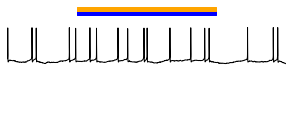

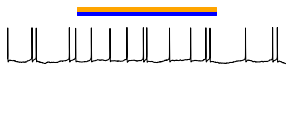

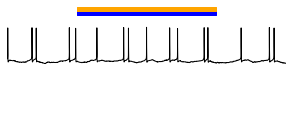

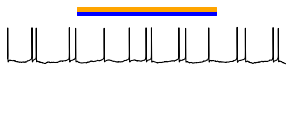

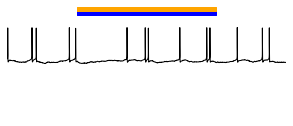

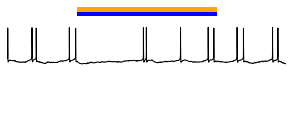

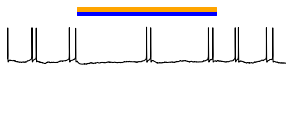

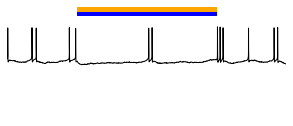

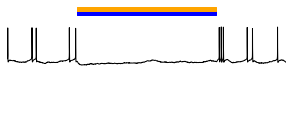

In [181]:
light_on = 2100
light_dur = 1000
tstop = 4000
buff = 100 # buffer
exp_repeat = {
    'expbase': '140616_replay_input_apic',
    #'description': 'irr%.3f_factor%.2f_spikes%g_J%.1f_cell%s_inh%.2f_freqfactor%g_shuffle%g_stim%s_NpHR_%s_ChR_%s',
    'description': 'irr%.3f_factor%.2f_spikes%g_J%.1f_cell%s_inh%.2f_freqfactor%g_shuffle%g_NpHR_%s_ChR_%s',
    'lightstart':2000,
    'lightstop': 3000,
    #'tstop': 4000,
    'tstart':1500,
    'tstop':3500,
    'scalesizex':500,
    'scalesizey': 50,
    }

#factors =[0.125, 0.25,0.5,1.,1.5,2.,4.,8.]
factors = np.arange(0.1,1.,0.1)
irr = 0.002
freq = 80
Js = 0.5
inh=-0.05
freqfactor =1
shuffle = 5
cell = 'L5PC'
stimtype = 'poisson'
for factor in factors:
    #ts,vm = get_trace(exp_repeat['description']%(irr,factor,freq,Js,cell,inh,freqfactor,shuffle,stimtype,exp_type,exp_type),**exp_repeat)
    ts,vm = get_trace(exp_repeat['description']%(irr,factor,freq,Js,cell,inh,freqfactor,shuffle,exp_type,exp_type),**exp_repeat)
    plot_trace(vm,ts,saveas='Fig6_repeat_traces_irr%.3f_factor%g_freq%g'%(irr,factor,freq),scalebar=False,**exp_repeat)


location = experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.000_factor0.12_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_stimpoisson_NpHR_none_ChR_none.dat
No file found:  experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.000_factor0.12_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_stimpoisson_NpHR_none_ChR_none.dat
trying location = experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.000_factor0.12_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_stimpoisson_NpHR_none_ChR_none_v.dat
['experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.000_factor0.12_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_stimpoisson_NpHR_none_ChR_none_v.dat']
Found it
experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.000_factor0.12_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_stimpoisson_NpHR_none_ChR_none_v.dat
None


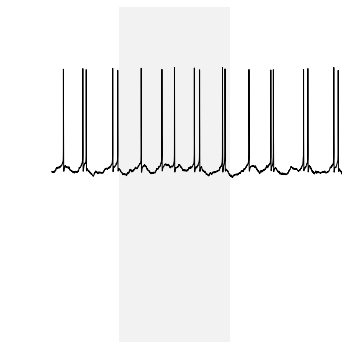

In [72]:
# plot original
# experiments/140616_replay_input_apic/dat/140616_replay_input_apicirr0.000_factor0.12_spikes80_J0.5_cellL5PC_inh-0.05_freqfactor1_shuffle5_stimpoisson_NpHR_none_ChR_none_v.dat
light_on = 2100
light_dur = 1000
tstop = 4000
buff = 100 # buffer
exp_repeat = {
    'expbase': '140616_replay_input_apic',
    'description': 'irr%.3f_factor%.2f_spikes%g_J%.1f_cell%s_inh%.2f_freqfactor%g_shuffle%g_stim%s_NpHR_%s_ChR_%s',
    'figsize':(6,6),
    'lightarea' : (2000,3000),
    'lightarea_alpha' : 0.1,
    'tstart':1400,
    'tstop':4000,
    'scalesizex':500,
    'scalesizey': 50,
    }

factors =[0.125]
irr = 0.
freq = 80
Js = 0.5
inh=-0.05
freqfactor =1
shuffle = 5
cell = 'L5PC'
stimtype = 'poisson'
exp_type = 'none'

for factor in factors:
    ts,vm = get_trace(exp_repeat['description']%(irr,factor,freq,Js,cell,inh,freqfactor,shuffle,stimtype,exp_type,exp_type),**exp_repeat)
    plot_trace(vm,ts,saveas='Fig6_originalTrace_irr%.3f_factor%g_freq%g'%(irr,factor,freq),scalebar=False,**exp_repeat)


In [71]:
%%capture
# plot high and low level illumination 
light_on = 2100
light_dur = 1000
tstop = 4000
buff = 100 # buffer
exp_repeat = {
    'expbase': '140616_replay_input_apic',
    'description': 'irr%.3f_factor%.2f_spikes%g_J%.1f_cell%s_inh%.2f_freqfactor%g_shuffle%g_stim%s_NpHR_%s_ChR_%s',
    'lightarea' : (2000,3000),
    'lightarea_alpha' : 0.1,
    
    'tstart':1400,
    'tstop':4000,
    'scalesizex':500,
    'scalesizey': 50,
    'figsize':(3,3),
    }

factors =[0.125,1.]#,1.5] #[0.125, 0.25,2.,4.,8.]
irrs = [0.002,2.]
freq = 80
Js = 0.5
inh=-0.05
freqfactor =1
shuffle = 5
cell = 'L5PC'
stimtype = 'poisson'
exp_type = 'whole'
for factor in factors:
    for irr in irrs:
        if factor >= 1.:
            exp_repeat['lightarea_color'] = '#FFA500'
        else:
            exp_repeat['lightarea_color'] = 'b'
        ts,vm = get_trace(exp_repeat['description']%(irr,factor,freq,Js,cell,inh,freqfactor,shuffle,stimtype,exp_type,exp_type),**exp_repeat)
        plot_trace(vm,ts,saveas='Fig6_repeat_traces_highLowLevelExamples_irr%.3f_factor%g_freq%g'%(irr,factor,freq),scalebar=False,**exp_repeat)
